<a href="https://colab.research.google.com/github/CreatlV/Deep-Learning-DD2424/blob/main/ExampleMitochondria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

2021-09-02 21:14:12.811214: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


In [3]:
# !zip -r augmented.zip augmented_data_U373

In [4]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import random
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime

In [5]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [6]:
# drive.mount('/content/drive')
%ls

'DataAugmentation(1).ipynb'                     dasmitochondria_test.hdf5
'ExampleMitochondria(1).ipynb'                  dasmitochondria_test_25.hdf5
 PhC-C2DH-U373-train/                           dasmitochondria_test_3.hdf5
 PhC-C2DH-U373-train-20210829T172421Z-001.zip   dasmitochondria_test_50.hdf5
 Untitled.ipynb                                 src/
 augmented.zip                                  tutorials/
 augmented_data_U373/


In [7]:
# %cd /content/drive/My\ Drive/Deep_Learning_Project/
# %ls
# image_directory = 'training'
# mask_directory = 'training_groundtruth'
image_directory = 'augmented_data_U373/X_labels'
mask_directory = 'augmented_data_U373/Y_labels'

In [10]:
SIZE = 512
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

In [8]:
images = sorted(os.listdir(image_directory))

In [9]:
images = sorted(os.listdir(image_directory))
images = [image for image in images if int(image.split('.')[0].split('_')[3])  < 2]
# print(images)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        #image = cv2.imread(image_directory+image_name, 0)
        image = cv2.imread(os.path.join(image_directory, image_name), cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
#         print(i)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

In [10]:
masks = sorted(os.listdir(mask_directory))
masks = [mask for mask in masks if int(mask.split('.')[0].split('_')[3])  < 2]

# print(masks)
#print(len(masks))
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        #image = cv2.imread(mask_directory+image_name, 0)
        image = cv2.imread(os.path.join(mask_directory, image_name), cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
#         print(i)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

In [11]:
# masks = sorted(os.listdir(mask_directory))
# masks = [mask for mask in masks if int(mask.split('.')[0].split('_')[3])  < 10]
# masks

In [12]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [13]:
print(len(image_dataset))
print(len(mask_dataset))
print(image_dataset[0].shape)

200
200
(512, 512, 1)


In [14]:
# print(np.nonzero(image_dataset))
# plt.imshow(np.reshape(X_train[50], (256, 256)))

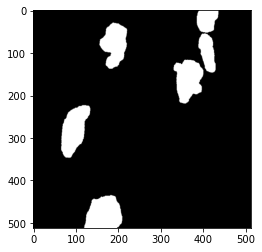

In [15]:
plt.imshow(mask_dataset[50].squeeze(), cmap='gray')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

163


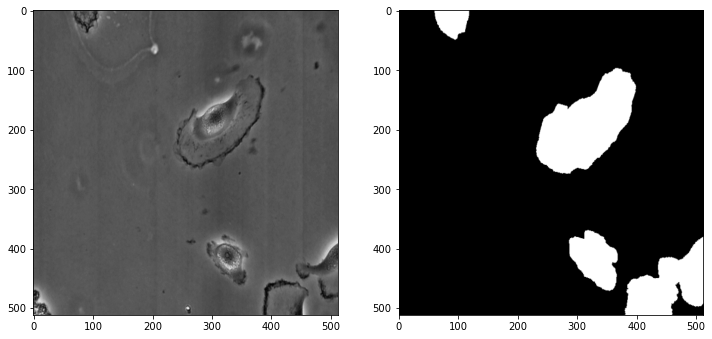

In [17]:
#Sanity check, view few mages
image_number = random.randint(0, len(X_train) - 1)
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (512, 512)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (512, 512)), cmap='gray')
plt.show()

In [18]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [19]:
%%capture
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

2021-09-02 20:54:07.351242: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-09-02 20:54:10.157751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-02 20:54:10.158689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-09-02 20:54:10.158761: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2021-09-02 20:54:10.192777: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2021-09-02 20:54:10.210918: I tensorflow/stream_executor/platform/defaul

In [20]:
import gc
images = []
masks = []
image_dataset = []
mask_dataset = []
gc.collect()

5836

In [22]:
history = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs=3, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save('dasmitochondria_test_3.hdf5')

Epoch 1/3
45/45 [==============================] - 134s 3s/step - loss: 5.3688 - accuracy: 0.8702 - val_loss: 0.3264 - val_accuracy: 0.8941
Epoch 2/3
45/45 [==============================] - 136s 3s/step - loss: 0.3425 - accuracy: 0.8857 - val_loss: 0.3071 - val_accuracy: 0.8941
Epoch 3/3
45/45 [==============================] - 136s 3s/step - loss: 0.3257 - accuracy: 0.8857 - val_loss: 0.2838 - val_accuracy: 0.8941


In [23]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 0s 2ms/step - loss: 0.2838 - accuracy: 0.8941
Accuracy =  89.4081711769104 %


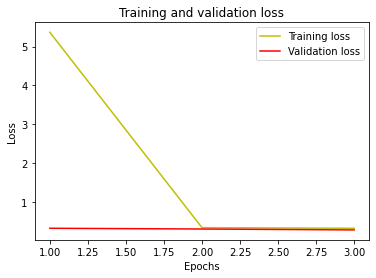

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

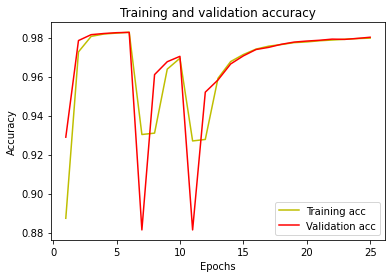

In [25]:
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
y_pred=model.predict(X_test)
# print(y_pred)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8997901141201363


In [27]:
# model = get_model()
model = tf.keras.models.load_model('dasmitochondria_test.hdf5')
# model.load_weights('dasmitochondria_test.hdf5') #Trained for 50 epochs and then additional 100
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')  #Trained for 50 epochs

In [30]:
test_img_number = random.randint(0, len(X_test))
print(X_test.shape)
print(test_img_number)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

(1000, 256, 256, 1)
602


In [31]:
# test_img_other = cv2.imread('data/test_images/02-1_256.tif', 0)

test_img_other = cv2.imread(os.path.join("PhC-C2DH-U373-train/02", "t001.tif"), cv2.IMREAD_UNCHANGED)
test_img_other_seg = cv2.imread(os.path.join("PhC-C2DH-U373-train/02_ST/SEG", 'man_seg000.tif'), cv2.IMREAD_UNCHANGED)

print(test_img_other_seg.shape)
test_img_other = Image.fromarray(test_img_other, 'L')

test_img_other_seg = (test_img_other_seg.astype(np.float)-test_img_other_seg.min())*255.0 / (test_img_other_seg.max()-test_img_other_seg.min())
test_img_other_seg = test_img_other_seg.astype(np.uint8)

test_img_other_seg[test_img_other_seg > 0] = 255
test_img_other_seg = Image.fromarray(test_img_other_seg, 'L')

test_img_other = test_img_other.resize((SIZE, SIZE))
test_img_other_seg = test_img_other_seg.resize((SIZE, SIZE))
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)

print(test_img_other)
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

(520, 696)
<PIL.Image.Image image mode=L size=256x256 at 0x7FD971C201D0>


In [32]:
#Predict and threshold for values above 0.5 probability
#Change the probability threshold to low value (e.g. 0.05) for watershed demo.
prediction_other = model.predict(test_img_other_input)

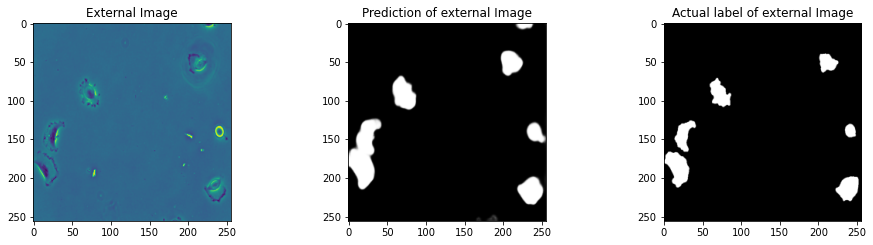

In [33]:
plt.figure(figsize=(16, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img[:,:,0], cmap='gray')
# plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(ground_truth[:,:,0], cmap='gray')
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other)
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(np.reshape(prediction_other, (256, 256)), cmap='gray')
plt.subplot(236)
plt.title('Actual label of external Image')
plt.imshow(test_img_other_seg, cmap='gray')
plt.show()

#plt.imsave('input.jpg', test_img[:,:,0], cmap='gray')
#plt.imsave('data/results/output2.jpg', prediction_other, cmap='gray')

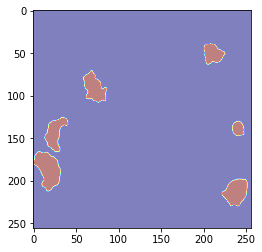

In [34]:
# plt.imshow(test_img_other, cmap='gray')
plt.imshow(test_img_other_seg, cmap='jet', alpha=0.5)

# O2 Test Dateset

In [11]:
test_directory = "PhC-C2DH-U373-train/02"
test_dataset = []

images = sorted(os.listdir(test_directory))

print(images)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(os.path.join(test_directory, image_name), cv2.IMREAD_UNCHANGED)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test_dataset.append(np.array(image))

# "NORMALIZE"
test_dataset = np.expand_dims(normalize(np.array(test_dataset), axis=1),3)

['t000.tif', 't001.tif', 't002.tif', 't003.tif', 't004.tif', 't005.tif', 't006.tif', 't007.tif', 't008.tif', 't009.tif', 't010.tif', 't011.tif', 't012.tif', 't013.tif', 't014.tif', 't015.tif', 't016.tif', 't017.tif', 't018.tif', 't019.tif', 't020.tif', 't021.tif', 't022.tif', 't023.tif', 't024.tif', 't025.tif', 't026.tif', 't027.tif', 't028.tif', 't029.tif', 't030.tif', 't031.tif', 't032.tif', 't033.tif', 't034.tif', 't035.tif', 't036.tif', 't037.tif', 't038.tif', 't039.tif', 't040.tif', 't041.tif', 't042.tif', 't043.tif', 't044.tif', 't045.tif', 't046.tif', 't047.tif', 't048.tif', 't049.tif', 't050.tif', 't051.tif', 't052.tif', 't053.tif', 't054.tif', 't055.tif', 't056.tif', 't057.tif', 't058.tif', 't059.tif', 't060.tif', 't061.tif', 't062.tif', 't063.tif', 't064.tif', 't065.tif', 't066.tif', 't067.tif', 't068.tif', 't069.tif', 't070.tif', 't071.tif', 't072.tif', 't073.tif', 't074.tif', 't075.tif', 't076.tif', 't077.tif', 't078.tif', 't079.tif', 't080.tif', 't081.tif', 't082.tif', 't0

In [12]:
test_mask_directory = "PhC-C2DH-U373-train/02_ST/SEG"
test_mask_dataset = []

masks = sorted(os.listdir(test_mask_directory))

for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(os.path.join(test_mask_directory, image_name), cv2.IMREAD_UNCHANGED)
        image = (image.astype(np.float)-image.min())*255.0 / (image.max()-image.min())
        image = image.astype(np.uint8)
        image = Image.fromarray(image)
        # print(image)
        image = image.resize((SIZE, SIZE))
        image = np.array(image)
        image[image > 0] = 255
        test_mask_dataset.append(image)
  
test_mask_dataset = np.expand_dims((np.array(test_mask_dataset)),3) /255.

In [13]:
%%capture
IMG_HEIGHT = 256
IMG_WIDTH = IMG_HEIGHT
IMG_CHANNELS = 1


model = tf.keras.models.load_model('dasmitochondria_test_3.hdf5')


2021-09-02 21:14:43.601376: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-09-02 21:14:46.353970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-02 21:14:46.354748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-09-02 21:14:46.354795: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2021-09-02 21:14:46.357671: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2021-09-02 21:14:46.358992: I tensorflow/stream_executor/platform/defaul

In [14]:
#PREDICT
y_pred = model.predict(test_dataset)
y_pred_thresholded = y_pred > 0.5

2021-09-02 21:14:48.233276: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8
2021-09-02 21:14:49.288413: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2021-09-02 21:15:58.541220: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-09-02 21:15:58.541264: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2021-09-02 21:16:10.267367: W tensorflow/core/common_runtime/bfc_allocator.cc:431] Allocator (GPU_0_bfc) ran out of memory try

ResourceExhaustedError:  OOM when allocating tensor with shape[32,128,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node functional_1/concatenate_3/concat (defined at tmp/ipykernel_2698/1303953140.py:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_2113]

Function call stack:
predict_function


In [ ]:
# COMPUTE IOU
intersection = np.logical_and(test_mask_dataset, y_pred_thresholded)
union = np.logical_or(test_mask_dataset, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

In [ ]:
# COMPUTE IOU
# print(np.shape(test_mask_dataset[0]))
# print(np.shape(np.nonzero(test_mask_dataset[0])))
test_mask_dataset[test_mask_dataset > 0] = 255
y_pred_thresholded[y_pred_thresholded > 0] = 255

print(1 - np.sum(np.logical_not(test_mask_dataset, y_pred_thresholded)) / (256 * 256 * 115))
# intersection = np.logical_and(test_mask_dataset, y_pred_thresholded)
# union = np.logical_or(test_mask_dataset, y_pred_thresholded)
# iou_score = np.sum(intersection) / np.sum(union)
# print("IoU socre is: ", np.sum(intersection) / (np.sum(intersection) + np.sum(union)))